In [1]:
import re
import sys
import json


import sys
sys.dont_write_bytecode = True
sys.path.append('../')
from datatools.analyzer import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

In [3]:
path = "../hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
convs = read_conv(path, datalist)

In [4]:
usr_sys = []
y = []
utt_list = []
errors = ["Ignore question", "Ignore offer", "Ignore proposal", "Ignore greeting"]
for conv in convs:
    for i, ut in enumerate( conv ) :
        utt_list.append(ut.utt)
        # システム発話で，無視系統のエラー
        # if ut.is_system() and ut.is_exist_error():
        if ut.is_system():
        # if ut.is_system():
            usr_sys.append( [conv[i-1].utt, ut.utt] )
            if ut.is_error_included(errors):
                y.append(1)
            else:
                y.append(0)

In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size, vocab_dict):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim,  padding_idx=0)
        # モデルを2つ定義
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        # self.lstm2 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.hidden2tag = nn.Linear(hidden_dim , tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()
    
        self.vocab_dict = vocab_dict
    
    def forward(self, x):
        emb1 = self.word_embeddings(x)
        _, lstm1_out = self.lstm1(emb1)
        tag_space = self.hidden2tag(torch.cat([ lstm1_out[0][0], lstm1_out[0][1]], dim=1 ))
        y =self.softmax(tag_space)
        return y
    
    def last_context(self, x):
        emb1 = self.word_embeddings(x)
        # print(emb1.shape)
        _, lstm1_out = self.lstm1(emb1)
        context = torch.cat([ lstm1_out[0][0], lstm1_out[0][1]], dim=1 )
        return context
    
    def text2context(self, text):
        if isinstance(text, str):
            utt_id = self._sentence2ids(text, self.vocab_dict)
            utt_id_tensor = torch.tensor( [utt_id] , device='cuda:0', dtype=torch.int)
            # utt_id_tensor = torch.tensor( [utt_id] , device='cpu', dtype=torch.int)
            return self.last_context(utt_id_tensor)
        if isinstance(text, list):
            X = self._make_X(text, self.vocab_dict)
            utt_id_tensor = X.to(torch.int).cuda()
            # utt_id_tensor = X.to(torch.int)
            return self.last_context(utt_id_tensor)
        else:
            return 0

        
    def _sentence2ids(self, sentence:str, vocab_dict:dict):
        doc = self._sentence2formated(sentence)
        ids = np.zeros(len(doc))
        for i, key in enumerate(doc):
            # key = token.orth_
            if key in vocab_dict:
                ids[i] = vocab_dict[key]
            else:
                ids[i] = vocab_dict["[UNK]"]
        return ids
    
    def _sentence2formated(self, sen):
        return sum( fill_SYMBOL_ONE( sentence2normalize_noun(sen) ), [] )
    
    def _padding_vector(self, Xseq):
        Xseq = [ torch.tensor( xseq[:, None] ) for xseq in Xseq]
        Xseq = rnn.pad_sequence(Xseq, batch_first=True)
        Xseq = [ torch.flatten(xseq) for xseq in Xseq ] 
        return Xseq


    def _make_X(self, utt_list:list, vocab_dict:dict):
        utt_id_list = []
        for utt in tqdm( utt_list) :
            utt_id = self._sentence2ids(utt, vocab_dict)
            utt_id_list.append(utt_id)

        utt_id_pad = self._padding_vector(utt_id_list)
        upl = len(utt_id_pad[0])
        # X =   [ torch.Tensor([u, s]) for u, s in zip(usr_id_pad, sys_id_pad) ] 
        # print(usr_pad_len, sys_pad_len)
        X = torch.zeros( (len(utt_list), upl) )
        for i, u in enumerate(utt_id_pad):
            X[i, :upl] = u
        return X
        

In [6]:
model_path = "../models/response2/"
model_name = "forward_v2.pickle"
modelM = DataManager(model_path)

In [40]:
forward_model = modelM.load_data(model_name)

success load : ../models/response2/forward_v2.pickle


In [8]:
us_train_str, us_test_str, y_train, y_test = train_test_split(usr_sys, y, test_size=0.30, random_state=5)

In [9]:
usr_train_str = [utt[0] for utt in us_train_str]
usr_test_str = [utt[0] for utt in us_test_str]

In [72]:
y.count(1)

310

In [41]:
with torch.no_grad():
    X_forward_train = forward_model.text2context(usr_train_str).cpu()
    X_forward_test = forward_model.text2context(usr_test_str).cpu()
del forward_model
torch.cuda.empty_cache()

100%|██████████| 1540/1540 [00:38<00:00, 39.79it/s]
/home/yamada/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
100%|██████████| 660/660 [00:17<00:00, 37.79it/s]


In [42]:
X_forward_train.requires_grad 

False

In [12]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
bert_path = "../../corpus/pretrained/sbert_ignore"
sbert = SentenceTransformer(bert_path)

[16935] 2021-12-16 00:42:56,623 Info sentence_transformers.SentenceTransformer :Load pretrained SentenceTransformer: ../../corpus/pretrained/sbert_ignore
[16935] 2021-12-16 00:42:58,100 Info sentence_transformers.SentenceTransformer :Use pytorch device: cuda


In [13]:
def text2vec(text):
    sentences = []
    if isinstance(text, str):
        sentences = [text]
    elif isinstance(text, list):
        sentences = text
    
    return sbert.encode(sentences)

def text2feature(text):
    vector = text2vec(text)
    diff = np.abs( vector[0] - vector[1] )
    return np.concatenate([vector.flatten(), diff])

In [14]:
X_sbert_train = [ text2feature(x) for x in us_train_str]
X_sbert_test = [ text2feature(x) for x in us_test_str]
del sbert
torch.cuda.empty_cache()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
X_train = torch.cat([X_forward_train, torch.stack( [ torch.from_numpy(xst).cpu() for xst in X_sbert_train])], dim=1)


In [46]:
print("X_for_train ",  X_forward_train.shape)
print("X_train ",  X_train.shape)

X_for_train  torch.Size([1540, 256])
X_train  torch.Size([1540, 2560])


In [47]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [73]:
class Classifier(nn.Module):
    def __init__(self, forward_dim, sbert_dim, sbert_hidden_dim, tagset_size):
        super(Classifier, self).__init__()  
        self.forward_dim = forward_dim
        self.sbert_sim = sbert_dim
        self.sbert_hidden_dim = sbert_hidden_dim

        self.hidden_dim = forward_dim + sbert_hidden_dim

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

        self.sbert2hid = nn.Linear(sbert_dim , sbert_hidden_dim)

        self.hidden2tag = nn.Linear(self.hidden_dim , tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()
    
    def forward(self, x):
        x_forward = x[:, :self.forward_dim]
        x_sbert = x[:, self.forward_dim:]
        
        sb_hidden = self.relu( self.sbert2hid(x_sbert) )
        sb_hidden = self.dropout(sb_hidden)
        # print( torch.cat([ x_forward, sb_hidden ], dim=1).shape )
        y = self.hidden2tag( torch.cat([ x_forward, sb_hidden ], dim=1) )
        y = self.softmax(y)
        return y


In [74]:
BATCH_SIZE = 32
epoch_ = 300
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [75]:
forward_dim = 256
sbert_dim = 2560 - forward_dim
sbert_hidden_dim = forward_dim*3
tagset_size = 2
print(forward_dim, sbert_dim, sbert_hidden_dim, tagset_size)

256 2304 768 2


In [76]:
model = Classifier(forward_dim, sbert_dim, sbert_hidden_dim, tagset_size)
if torch.cuda.is_available():
   model.cuda()
   # model.cpu()
loss_function = nn.NLLLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [77]:
losses = []
from tqdm import tqdm
for epoch in tqdm( range(epoch_) ):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        X_tens= data[0].float().cuda()
        y_tens = torch.tensor(data[1], device='cuda:0').long()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape , y_t_tensor.view(-1,1).shape)

        score = model(X_tens)
        # print(X_t_tensor.shape, score.view(-1,5).shape, y_t_tensor.view(-1,1).shape)
        loss_ = loss_function(score, y_tens)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)

  0%|          | 0/300 [00:00<?, ?it/s]/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 17%|█▋        | 50/300 [00:33<02:43,  1.53it/s]

epoch 50 	 loss 0.07686184009065755


 33%|███▎      | 100/300 [01:06<02:13,  1.50it/s]

epoch 100 	 loss 0.0072217492042909726


 50%|█████     | 150/300 [01:39<01:37,  1.54it/s]

epoch 150 	 loss 0.0014533573170183445


 67%|██████▋   | 200/300 [02:13<01:09,  1.43it/s]

epoch 200 	 loss 0.00032691494141090516


 83%|████████▎ | 250/300 [02:47<00:33,  1.51it/s]

epoch 250 	 loss 8.109860254990053e-05


100%|██████████| 300/300 [03:22<00:00,  1.48it/s]

epoch 300 	 loss 0.005446522520742292


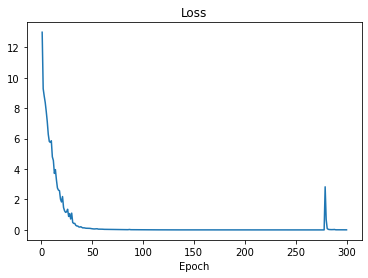

In [78]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [79]:
X_test= torch.cat([X_forward_test, torch.stack( [ torch.from_numpy(xst).cpu() for xst in X_sbert_test])], dim=1)
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, device='cuda:0').long()
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [80]:
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[529  42]
 [ 37  52]]
accuracy =  0.8803030303030303
precision =  0.5531914893617021
recall =  0.5842696629213483
f1 score =  0.5683060109289617
